

























































































































































































































































































































































































































































































































































































# PhysioNet EEG Motor Imagery: CNN vs GCN

This notebook adapts the previously built BCI Competition workflow to the PhysioNet Motor Movement/Imagery dataset by:
- loading a manageable chunk of the data,
- exploring channel behavior with matplotlib and seaborn, and
- training convolutional and graph convolutional baselines.


## Dataset Overview
PhysioNet's EEG Motor Movement/Imagery dataset provides 64-channel recordings for 109 subjects performing motor imagery and motor execution tasks. We focus on the imagery runs (R03, R04, R07, R08) and sample only a subset of subjects and epochs so that the notebook can run quickly while still reflecting the dataset's structure.

The EDF files are already downloaded under physionet/files/SXXX. Each run has accompanying annotation markers (for example 'T1' left fist, 'T2' right fist, 'T3' both fists, 'T4' both feet). We remap these annotations to descriptive labels for modeling.


## Environment Setup
If you are running this notebook in a fresh environment, make sure the scientific Python stack is available.
Run the following cell if any imports below fail:

!pip install mne pyedflib seaborn matplotlib pandas scikit-learn tensorflow


In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mne
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import display

plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore', category=RuntimeWarning)


## Data Chunk Configuration
We limit the analysis to a small, representative slice of the dataset so the notebook remains interactive. Adjust the constants below if you want to explore more subjects, runs, or epochs.


In [2]:
DATA_ROOT = Path('physionet/files')
SELECTED_SUBJECTS = ['S001', 'S002', 'S003']
SELECTED_RUNS = ['R03', 'R04', 'R07', 'R08']
MAX_EPOCHS_PER_RUN = 60
EPOCH_TMIN = -0.2  # seconds relative to cue onset
EPOCH_TMAX = 4.0   # seconds post-cue
BANDPASS = (1.0, 40.0)

assert DATA_ROOT.exists(), f'Expected PhysioNet data under {DATA_ROOT.resolve()}'


## Helper Utilities
The loader below parses EDF files, extracts motor imagery events, filters the EEG, and returns NumPy arrays together with metadata for EDA.


In [3]:
EVENT_LABEL_MAP = {
    'T1': 'left_fist',
    'T2': 'right_fist',
    'T3': 'both_fists',
    'T4': 'both_feet',
}


def load_physionet_chunk(root, subjects, runs, tmin, tmax, max_epochs_per_run=None, bandpass=None):
    data_blocks = []
    label_blocks = []
    meta_rows = []
    info = None

    for subject in subjects:
        for run in runs:
            edf_path = root / subject / f'{subject}{run}.edf'
            if not edf_path.exists():
                print(f'[skip] Missing {edf_path}')
                continue

            raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False, stim_channel=None)

            if bandpass is not None:
                raw.filter(bandpass[0], bandpass[1], fir_design='firwin', verbose=False)

            events, event_id = mne.events_from_annotations(raw, verbose=False)

            selected_event_id = {}
            for annotation, code in event_id.items():
                if annotation in EVENT_LABEL_MAP:
                    selected_event_id[EVENT_LABEL_MAP[annotation]] = code

            if not selected_event_id:
                print(f'[skip] No motor imagery markers in {edf_path.name}')
                continue

            picks = mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads')
            epochs = mne.Epochs(
                raw,
                events,
                event_id=selected_event_id,
                tmin=tmin,
                tmax=tmax,
                baseline=None,
                preload=True,
                picks=picks,
                verbose=False,
            )

            if max_epochs_per_run is not None:
                epochs = epochs[:max_epochs_per_run]

            epoch_data = epochs.get_data()
            inverse_event_id = {v: k for k, v in epochs.event_id.items()}
            epoch_labels = [inverse_event_id[event_code] for event_code in epochs.events[:, 2]]

            data_blocks.append(epoch_data)
            label_blocks.extend(epoch_labels)
            meta_rows.extend(
                {
                    'subject': subject,
                    'run': run,
                    'label': label,
                }
                for label in epoch_labels
            )

            if info is None:
                info = epochs.info

            print(f'[loaded] {subject}{run}: {len(epoch_labels)} epochs')

    if not data_blocks:
        raise RuntimeError('No data loaded. Check the selected subjects/runs and file paths.')

    data = np.concatenate(data_blocks, axis=0)
    metadata = pd.DataFrame(meta_rows)
    labels = np.array(label_blocks)

    return data, labels, metadata, info


In [4]:
X_raw, labels_str, meta_df, info = load_physionet_chunk(
    DATA_ROOT,
    SELECTED_SUBJECTS,
    SELECTED_RUNS,
    tmin=EPOCH_TMIN,
    tmax=EPOCH_TMAX,
    max_epochs_per_run=MAX_EPOCHS_PER_RUN,
    bandpass=BANDPASS,
)

sfreq = info['sfreq']
channel_names = info['ch_names']

print(f'Loaded epochs shape: {X_raw.shape}')
print('Unique labels:', np.unique(labels_str))

display(meta_df.head())


[loaded] S001R03: 15 epochs
[loaded] S001R04: 15 epochs
[loaded] S001R07: 15 epochs
[loaded] S001R08: 15 epochs
[loaded] S002R03: 15 epochs
[loaded] S002R04: 15 epochs
[loaded] S002R07: 15 epochs
[loaded] S002R08: 15 epochs
[loaded] S003R03: 15 epochs
[loaded] S003R04: 15 epochs
[loaded] S003R07: 15 epochs
[loaded] S003R08: 15 epochs
Loaded epochs shape: (180, 64, 673)
Unique labels: ['left_fist' 'right_fist']


,subject,run,label
0,S001,R03,right_fist
1,S001,R03,left_fist
2,S001,R03,left_fist
3,S001,R03,right_fist
4,S001,R03,right_fist


## Exploratory Data Analysis
We start with a quick look at label balance, run distribution, and the morphology of representative channels.


,label,count
0,left_fist,92
1,right_fist,88


C:\Users\SHIVAPREETHAM ROHITH\AppData\Local\Temp\ipykernel_12712\377328669.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_counts, x='label', y='count', palette='viridis')


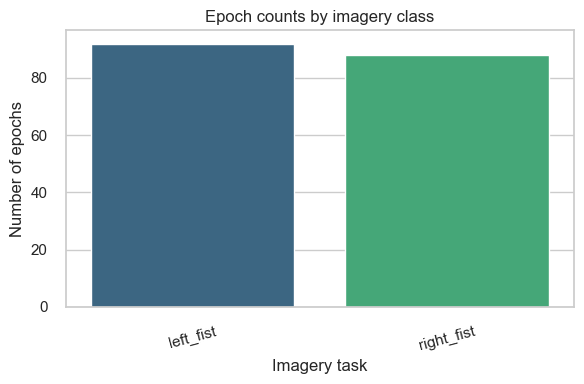

In [5]:
label_counts = (
    meta_df['label']
    .value_counts()
    .rename_axis('label')
    .reset_index(name='count')
)

display(label_counts)

plt.figure(figsize=(6, 4))
sns.barplot(data=label_counts, x='label', y='count', palette='viridis')
plt.title('Epoch counts by imagery class')
plt.xlabel('Imagery task')
plt.ylabel('Number of epochs')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


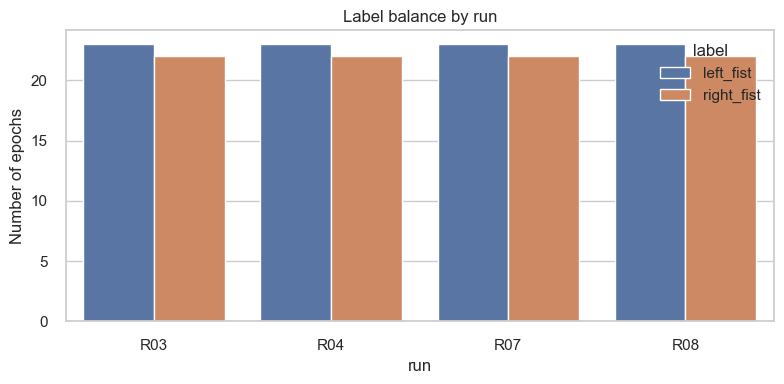

In [6]:
run_summary = (
    meta_df
    .groupby(['run', 'label'])
    .size()
    .reset_index(name='count')
    .sort_values(['run', 'label'])
)

plt.figure(figsize=(8, 4))
sns.barplot(data=run_summary, x='run', y='count', hue='label')
plt.title('Label balance by run')
plt.ylabel('Number of epochs')
plt.tight_layout()
plt.show()


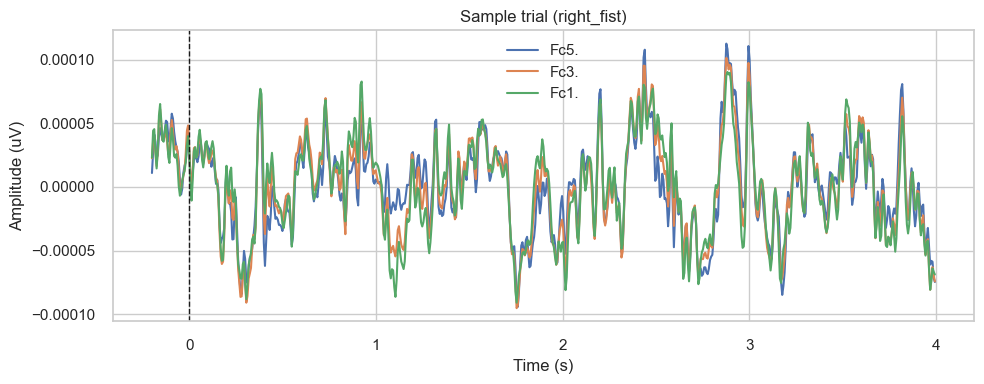

In [7]:
time_vector = np.linspace(EPOCH_TMIN, EPOCH_TMAX, X_raw.shape[-1], endpoint=False)
preferred_channels = ['C3', 'Cz', 'C4']
available_channels = [ch for ch in preferred_channels if ch in channel_names]
if not available_channels:
    available_channels = channel_names[:3]

trial_index = 0
plt.figure(figsize=(10, 4))
for ch in available_channels:
    ch_idx = channel_names.index(ch)
    plt.plot(time_vector, X_raw[trial_index, ch_idx], label=ch)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Sample trial ({labels_str[trial_index]})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.legend()
plt.tight_layout()
plt.show()


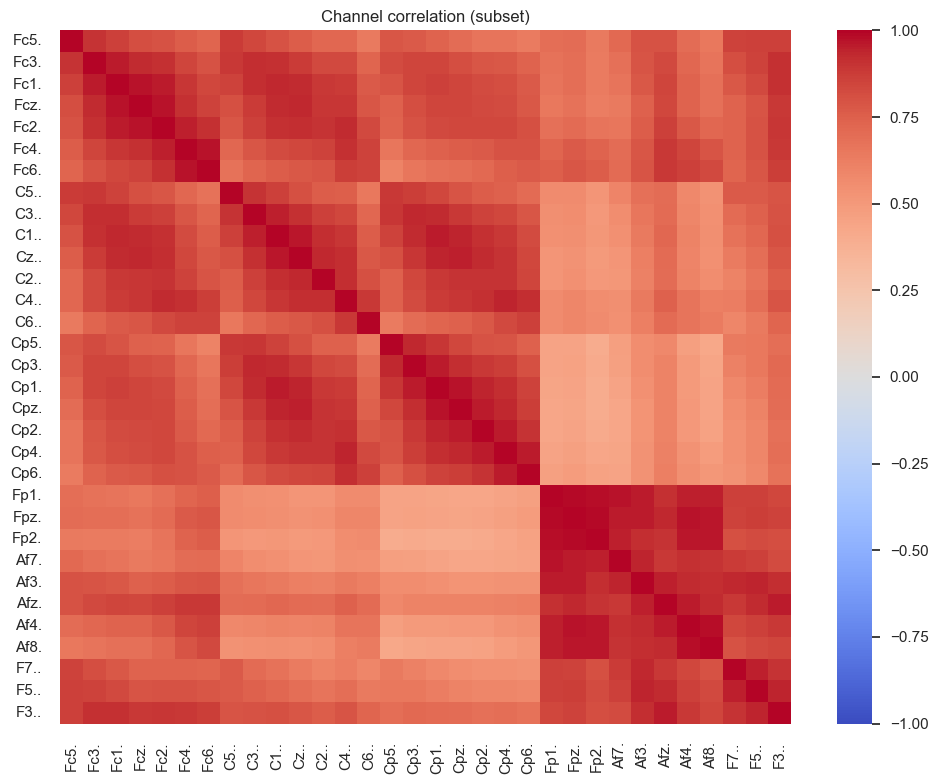

In [8]:
subset_size = min(32, len(channel_names))
subset_idx = list(range(subset_size))
subset_channels = [channel_names[i] for i in subset_idx]

channel_matrix = X_raw[:, subset_idx, :].transpose(1, 0, 2).reshape(subset_size, -1)
corr_matrix = np.corrcoef(channel_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    cmap='coolwarm',
    xticklabels=subset_channels,
    yticklabels=subset_channels,
)
plt.title('Channel correlation (subset)')
plt.tight_layout()
plt.show()


## Prepare Data for Modeling
We encode labels, standardize the EEG amplitudes channel-wise, and create a train/validation split.


In [9]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(labels_str)
class_names = list(label_encoder.classes_)
y_cat = keras.utils.to_categorical(y_int, num_classes=len(class_names))

num_epochs, num_channels, num_timepoints = X_raw.shape
num_classes = len(class_names)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw.reshape(num_epochs, -1)).reshape(num_epochs, num_channels, num_timepoints)

X_train, X_val, y_train, y_val, y_train_int, y_val_int = train_test_split(
    X_scaled,
    y_cat,
    y_int,
    test_size=0.2,
    random_state=42,
    stratify=y_int,
)

print(f'Train set: {X_train.shape}, Validation set: {X_val.shape}')
print('Classes:', class_names)


Train set: (144, 64, 673), Validation set: (36, 64, 673)
Classes: ['left_fist', 'right_fist']


## Graph Construction
A simple Pearson-correlation graph captures functional relationships between channels on the training split. The rescaled Laplacian feeds the Chebyshev graph convolution later.


In [10]:
def compute_adjacency_from_pearson(data):
    n_epochs, n_channels, n_times = data.shape
    flattened = data.transpose(1, 0, 2).reshape(n_channels, -1)
    corr = np.corrcoef(flattened)
    adjacency = np.abs(corr)
    np.fill_diagonal(adjacency, 1.0)
    return adjacency.astype(np.float32)


def compute_laplacian(adjacency):
    degree = np.sum(adjacency, axis=1)
    degree_inv_sqrt = np.diag(1.0 / np.sqrt(degree + 1e-6))
    laplacian = np.eye(len(adjacency)) - degree_inv_sqrt @ adjacency @ degree_inv_sqrt
    lambda_max = np.linalg.eigvalsh(laplacian)[-1]
    laplacian_rescaled = (2.0 / lambda_max) * laplacian - np.eye(len(adjacency))
    return laplacian_rescaled.astype(np.float32)

adjacency = compute_adjacency_from_pearson(X_train)
L_rescaled = compute_laplacian(adjacency)

print('Adjacency shape:', adjacency.shape)


Adjacency shape: (64, 64)


## CNN Baseline
A temporal convolutional network provides a strong baseline for sequence modeling directly on the EEG channels.


In [11]:
def create_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)

    x = layers.Conv1D(64, kernel_size=50, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, kernel_size=25, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(256, kernel_size=10, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='physionet_cnn')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn((num_channels, num_timepoints), num_classes)
cnn_model.summary()


Model: "physionet_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 673)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 673, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 673, 64)        │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 673, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 336, 128)       │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 336, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 168, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 168, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 772,674 (2.95 MB)

 Trainable params: 771,778 (2.94 MB)

 Non-trainable params: 896 (3.50 KB)

## Graph-Enhanced Model
We augment the CNN features with a Chebyshev graph convolution over channel averages to inject spatial structure.


In [12]:
class ChebyshevGraphConv(layers.Layer):
    def __init__(self, num_filters, K=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters
        self.K = K

    def build(self, input_shape):
        input_dim = input_shape[0][-1]
        self.theta = [
            self.add_weight(
                shape=(input_dim, self.num_filters),
                initializer='glorot_uniform',
                name=f'theta_{k}',
            )
            for k in range(self.K)
        ]
        super().build(input_shape)

    def call(self, inputs):
        x, laplacian = inputs
        tx_0 = x
        tx_1 = tf.matmul(laplacian, x)
        outputs = tf.matmul(tx_0, self.theta[0])
        if self.K > 1:
            outputs += tf.matmul(tx_1, self.theta[1])
        for k in range(2, self.K):
            tx_2 = 2.0 * tf.matmul(laplacian, tx_1) - tx_0
            outputs += tf.matmul(tx_2, self.theta[k])
            tx_0, tx_1 = tx_1, tx_2
        return outputs


def create_gcn(input_shape, num_classes, laplacian):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)

    x = layers.Conv1D(64, kernel_size=50, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, kernel_size=25, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    cnn_features = x

    channel_input = layers.Input(shape=input_shape)
    channel_avg = layers.Lambda(lambda tensor: tf.reduce_mean(tensor, axis=-1, keepdims=True))(channel_input)

    laplacian_tensor = tf.constant(laplacian, dtype=tf.float32)
    graph_features = ChebyshevGraphConv(64, K=2)([channel_avg, laplacian_tensor])
    graph_features = layers.Flatten()(graph_features)

    combined = layers.Concatenate()([cnn_features, graph_features])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = keras.Model(inputs=[inputs, channel_input], outputs=outputs, name='physionet_gcn')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

gcn_model = create_gcn((num_channels, num_timepoints), num_classes, L_rescaled)
gcn_model.summary()


Model: "physionet_gcn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 673)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 673, 64)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 673, 64)   │    204,864 │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 673, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 336, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 336, 64)   │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 64, 673)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 336, 128)  │    204,928 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 1)     │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 336, 128)  │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chebyshev_graph_co… │ (None, 64, 64)    │        128 │ lambda[0][0]      │
│ (ChebyshevGraphCon… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ chebyshev_graph_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4224)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    540,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 951,746 (3.63 MB)

 Trainable params: 951,362 (3.63 MB)

 Non-trainable params: 384 (1.50 KB)

## Training
Train both models on the scaled chunk. Adjust epochs and batch size depending on available compute.


In [13]:
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
        }
        self.best_val_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key in self.history:
            self.history[key].append(logs.get(key))
        current_val = logs.get('val_accuracy')
        if current_val is not None and current_val > self.best_val_accuracy:
            self.best_val_accuracy = current_val

EPOCHS = 25
BATCH_SIZE = 32

cnn_metrics = MetricsCallback()
cnn_history = cnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        cnn_metrics,
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ],
    verbose=2,
)


Epoch 1/25
5/5 - 9s - 2s/step - accuracy: 0.4792 - loss: 0.8694 - val_accuracy: 0.5000 - val_loss: 1.1273
Epoch 2/25
5/5 - 3s - 503ms/step - accuracy: 0.5833 - loss: 0.7625 - val_accuracy: 0.5000 - val_loss: 1.3629
Epoch 3/25
5/5 - 2s - 483ms/step - accuracy: 0.5972 - loss: 0.7398 - val_accuracy: 0.5000 - val_loss: 1.6105
Epoch 4/25
5/5 - 3s - 517ms/step - accuracy: 0.5903 - loss: 0.6812 - val_accuracy: 0.5000 - val_loss: 1.6053
Epoch 5/25
5/5 - 3s - 510ms/step - accuracy: 0.6389 - loss: 0.6405 - val_accuracy: 0.5556 - val_loss: 0.8290
Epoch 6/25
5/5 - 3s - 539ms/step - accuracy: 0.6319 - loss: 0.6708 - val_accuracy: 0.5000 - val_loss: 0.6716
Epoch 7/25
5/5 - 3s - 527ms/step - accuracy: 0.7639 - loss: 0.5265 - val_accuracy: 0.5000 - val_loss: 1.2729
Epoch 8/25
5/5 - 3s - 502ms/step - accuracy: 0.7292 - loss: 0.5025 - val_accuracy: 0.5278 - val_loss: 1.1048
Epoch 9/25
5/5 - 3s - 514ms/step - accuracy: 0.8333 - loss: 0.3997 - val_accuracy: 0.5000 - val_loss: 1.1645
Epoch 10/25
5/5 - 2s -

In [14]:
gcn_metrics = MetricsCallback()
gcn_history = gcn_model.fit(
    [X_train, X_train],
    y_train,
    validation_data=([X_val, X_val], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        gcn_metrics,
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ],
    verbose=2,
)


Epoch 1/25
5/5 - 11s - 2s/step - accuracy: 0.4931 - loss: 0.7145 - val_accuracy: 0.5000 - val_loss: 1.0630
Epoch 2/25
5/5 - 2s - 396ms/step - accuracy: 0.5764 - loss: 0.6877 - val_accuracy: 0.5000 - val_loss: 0.9551
Epoch 3/25
5/5 - 2s - 419ms/step - accuracy: 0.5833 - loss: 0.6739 - val_accuracy: 0.5000 - val_loss: 2.0533
Epoch 4/25
5/5 - 2s - 422ms/step - accuracy: 0.6042 - loss: 0.6495 - val_accuracy: 0.5000 - val_loss: 2.0301
Epoch 5/25
5/5 - 2s - 470ms/step - accuracy: 0.6042 - loss: 0.6375 - val_accuracy: 0.5000 - val_loss: 1.2766
Epoch 6/25
5/5 - 2s - 411ms/step - accuracy: 0.7500 - loss: 0.5705 - val_accuracy: 0.5000 - val_loss: 1.4674


## Compare Learning Curves
Visualize how the training and validation metrics evolve for each model on the chunked dataset.


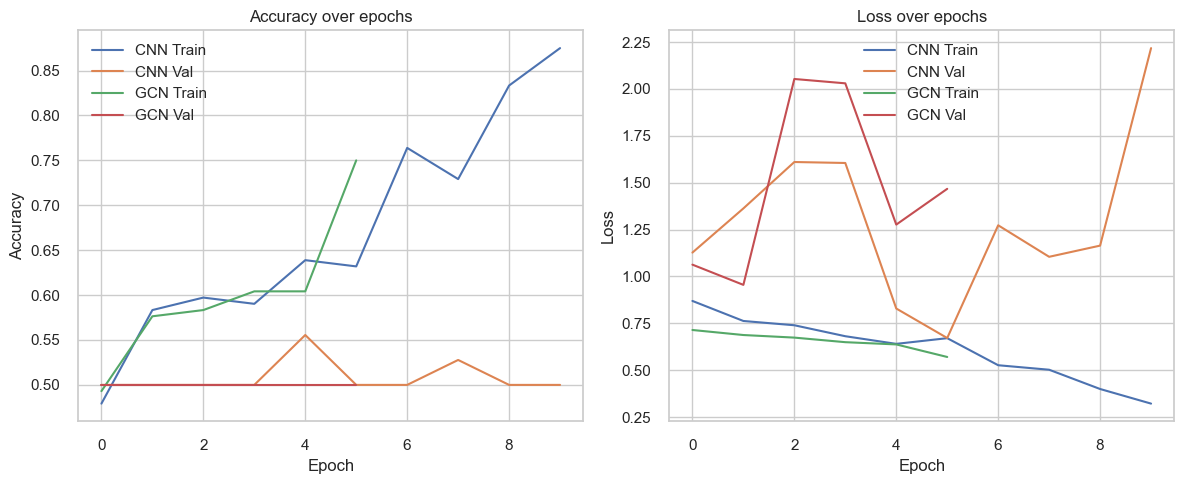

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Train')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
plt.plot(gcn_history.history['accuracy'], label='GCN Train')
plt.plot(gcn_history.history['val_accuracy'], label='GCN Val')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.plot(gcn_history.history['loss'], label='GCN Train')
plt.plot(gcn_history.history['val_loss'], label='GCN Val')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
cnn_val_metrics = cnn_model.evaluate(X_val, y_val, verbose=0)
gcn_val_metrics = gcn_model.evaluate([X_val, X_val], y_val, verbose=0)

print(f'CNN validation accuracy: {cnn_val_metrics[1]:.3f}')
print(f'GCN validation accuracy: {gcn_val_metrics[1]:.3f}')


CNN validation accuracy: 0.556
GCN validation accuracy: 0.500


## Next Steps
- Expand the subject and run lists to leverage more of PhysioNet once you are satisfied with runtime.
- Experiment with different graph constructions (distance-based, mutual information, coherence).
- Try cross-subject or leave-one-subject-out splits to stress-test generalisation.
